In [1]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt

import hist
import scipy
from scipy import optimize

In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/df_test_sample_hard_scattering/"
savedir = "/home/chardong/y_identification/Venv/save_plots/"
df = pd.read_pickle(datadir+"df_test_combined_sample_hard_scattering_skim30.pkl")

In [3]:
#datadir = "/Users/Marco/Data/PhotonID/Run2/"
#savedir = "/Users/Marco/Data/PhotonID/Run2/"
filein = "test_sample_hard_scattering.pkl"

In [4]:
df = pd.read_pickle(datadir+filein)

In [5]:
df.head(5)

,y_pt,y_eta,y_phi,y_convRadius,y_convType,background_score,signal_score,truth_label,weight,y_IsTight,y_IsLoose,evt_mu
0,161.701477,0.362196,2.487155,629.981873,2,0.021797,0.978203,1.0,4.248286,True,True,26.490000
1,385.804260,1.128969,-1.012413,306.678284,5,0.030782,0.969218,1.0,0.175998,True,True,28.490000
2,103.813927,-1.250267,-1.753746,9999.000000,0,0.018690,0.981310,1.0,29.921994,True,True,15.500000
3,49.413609,1.750125,0.338590,646.382996,2,0.050701,0.949299,1.0,631.878759,False,True,34.490002
4,71.762466,1.366162,1.486376,9999.000000,0,0.022225,0.977775,1.0,47.314782,True,True,25.490000


In [6]:
edges_eta= [0 , 0.6  ,  0.8  ,  1.15  ,  1.37  , 1.52 ,  1.81  ,  2.01  ,  2.37 ]

edges_mu = [0., 10., 20., 30., 40., 50., 60., 70., 80., 90., 100.]
#edges_mu = [20., 30., 40., 50., 60., 70., 80.]

edges_pt_bkg = [ 20.,  25.,  30.,  35.,  40.,  45., 50., 55., 65., 80., 500. ]

edges_pt_sig = [ 20.,    25.,    30.,    35.,    40.,
                 45.,    50.,    55.,    60.,    65.,
                 70.,    75.,    80.,    85.,    90.,
                 95.,   100.,   110.,   120.,   140.,   
                145.,   150.,   155.,   160.,   165.,
                175.,   190.,   205.,   230.,   280.,   
                285.,   290.,   300.,   305.,   315.,
                325.,   340.,   355.,   370.,   395.,   
                430.,   500.]

In [7]:
axis_mu     = hist.axis.Variable(edges_mu,      name='mu',   label=r"$\mu$")
axis_eta    = hist.axis.Variable(edges_eta,     name="eta",  label=r"$\eta$")
axis_pt_sig = hist.axis.Variable(edges_pt_sig,  name='pt',   label=r"$p_T$ [GeV]")
axis_pt_bkg = hist.axis.Variable(edges_pt_bkg,  name='pt',   label=r"$p_T$ [GeV]")

index_mu_eta = pd.MultiIndex.from_product(
    [range(axis_mu.size), range(len(axis_eta.edges) - 1)], names=["mu_bin", "eta_bin"]
)

index_pt_eta = pd.MultiIndex.from_product(
    [range(axis_pt_bkg.size), range(len(axis_eta.edges) - 1)], names=["pt_bin_bkg", "eta_bin"]
)

In [33]:
# Preselection on photon passing Loose cut-based selection 
df = df.query('y_IsLoose == 1')

# Restict pT range to pT histogram edges also for mu plot to avoid artifacts
df = df.query('20. < y_pt < 500.')

# Adding column with absolute eta value, assuming symmetry
df['y_abs_eta'] = np.abs(df['y_eta'])

# Assiging indices correspoding to bins to each event in dataset
df = df.assign(pt_bin_sig=axis_pt_sig.index(df['y_pt']))
df = df.assign(pt_bin_bkg=axis_pt_bkg.index(df['y_pt']))
df = df.assign(eta_bin=axis_eta.index(df['y_abs_eta']))
df = df.assign(mu_bin=axis_mu.index(df['evt_mu']))

In [34]:
df_sig = df[df['truth_label']==1]
df_bkg = df[df['truth_label']==0]

In [35]:
df_sig_tight = df_sig[(df_sig["y_IsTight"]==True)]
df_bkg_tight = df_bkg[(df_bkg["y_IsTight"]==True)]

In [36]:
def efficiency(num,den):
    eff = (num/den).values()
    efferr = np.sqrt(eff*(1.-eff)/den.values())
    return eff, efferr

### Tight efficiencies as a function of $\eta$ and $\mu$ and of $\eta$ and $p_T$

In [37]:
den_sig_EtaMu = hist.Hist(axis_eta, axis_mu).fill(df_sig["y_abs_eta"], df_sig["evt_mu"])
den_bkg_EtaMu = hist.Hist(axis_eta, axis_mu).fill(df_bkg["y_abs_eta"], df_bkg["evt_mu"])

num_sig_tight_EtaMu = hist.Hist(axis_eta, axis_mu).fill(df_sig_tight["y_abs_eta"], df_sig_tight["evt_mu"])
num_bkg_tight_EtaMu = hist.Hist(axis_eta, axis_mu).fill(df_bkg_tight["y_abs_eta"], df_bkg_tight["evt_mu"])

eff_sig_tight_EtaMu, efferr_sig_tight_EtaMu = efficiency(num_sig_tight_EtaMu,den_sig_EtaMu)
eff_bkg_tight_EtaMu, efferr_bkg_tight_EtaMu = efficiency(num_bkg_tight_EtaMu,den_bkg_EtaMu)

In [38]:
den_sig_EtapT = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig["y_abs_eta"], df_sig["y_pt"])
den_bkg_EtapT = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg["y_abs_eta"], df_bkg["y_pt"])

num_sig_tight_EtapT = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig_tight["y_abs_eta"], df_sig_tight["y_pt"])
num_bkg_tight_EtapT = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_tight["y_abs_eta"], df_bkg_tight["y_pt"])

eff_sig_tight_EtapT, efferr_sig_tight_EtapT = efficiency(num_sig_tight_EtapT,den_sig_EtapT)
eff_bkg_tight_EtapT, efferr_bkg_tight_EtapT = efficiency(num_bkg_tight_EtapT,den_bkg_EtapT)

In [39]:
mu     = axis_mu.centers
pt_sig = axis_pt_sig.centers
pt_bkg = axis_pt_bkg.centers
eta    = axis_eta.centers

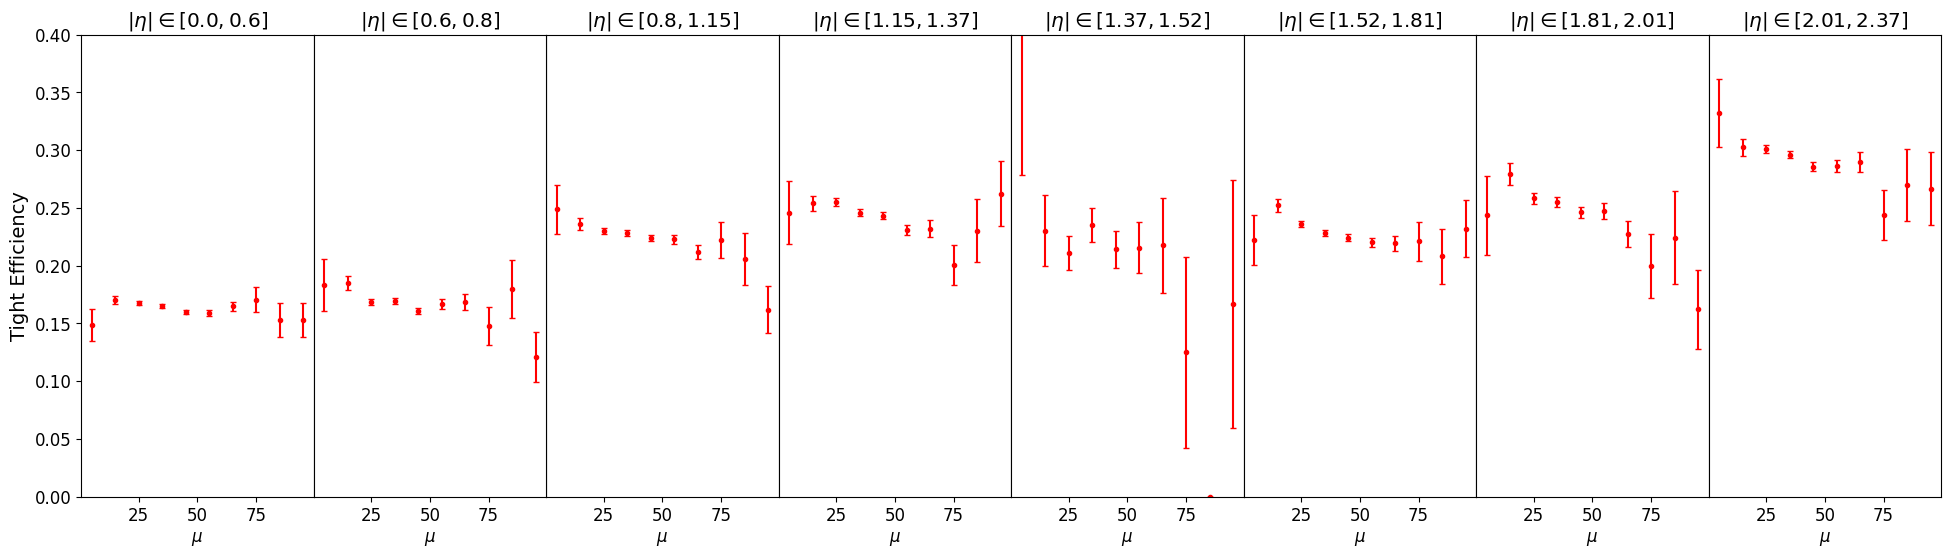

In [40]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_bkg_tight_EtaMu[i], yerr=efferr_bkg_tight_EtaMu[i],
                   fmt=".", capsize=2, 
                   label='fake $\gamma$', 
                   color = 'red')  
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlabel('$\mu$')
    #ax[i].set_ylim([0.8, 1.0])
    ax[i].set_ylim([0.,0.4])
           
ax[0].set_ylabel("Tight Efficiency",  fontsize=14)
ax[1].set_zorder(ax[1].get_zorder() + 1)
#ax[1].legend(fontsize = 12)

plt.show()

## BDT working point optimization

In [41]:
def compute_eff_BDT(df, threshold):
    '''Return efficienty of a given selection on BDT score'''
    r = (df['signal_score'] > threshold).sum() / len(df) 
    return r

In [42]:
def find_cut_with_root_scalar(df, target_efficiency):
    '''Find selection on BDT score correponsing to target effeciency'''
    r = scipy.optimize.root_scalar(                
        lambda x: compute_eff_BDT(df, x) - target_efficiency, bracket=(0., 1.0),
        method='brenth', options={'xtol': 1E-5, 'maxiter': 50}
        )
    return r.root

### WP1: cuts are defined as a function of $\eta$ and $\mu$

In [43]:
df_bkg_indexed_mueta = df_bkg.set_index(['mu_bin','eta_bin']).sort_index()

bdt_cut_same_background_efficiency_tight_mueta = {}

for (ieta, imu), eff_tight in np.ndenumerate(eff_bkg_tight_EtaMu): 
    df_bin = df_bkg_indexed_mueta.loc[imu, ieta]
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency=eff_tight)
    bdt_cut_same_background_efficiency_tight_mueta[imu, ieta] = cut_BDT

BDTcut_samebkgeff_tight_mueta = pd.Series(bdt_cut_same_background_efficiency_tight_mueta).sort_index()
BDTcut_samebkgeff_tight_mueta.index.names = ['mu_bin', 'eta_bin']

df = df.merge(BDTcut_samebkgeff_tight_mueta.rename('BDTcut_samebkgeff_tight_mueta'), on=['mu_bin', 'eta_bin'], how="left")
df = df.assign(pass_BDTcut_samebkgeff_tight_mueta = df['signal_score'] > df['BDTcut_samebkgeff_tight_mueta'])
df.drop('BDTcut_samebkgeff_tight_mueta',axis=1,inplace=True)

### WP2: cuts are defined as a function of $\eta$ and $p_T$

In [44]:
df_bkg_indexed_pteta = df_bkg.set_index(['pt_bin_bkg','eta_bin']).sort_index()

bdt_cut_same_background_efficiency_tight_pteta = {}

for (ieta, ipt), eff_tight in np.ndenumerate(eff_bkg_tight_EtapT): 
    df_bin = df_bkg_indexed_pteta.loc[ipt, ieta]
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency=eff_tight)
    bdt_cut_same_background_efficiency_tight_pteta[ipt, ieta] = cut_BDT

BDTcut_samebkgeff_tight_pteta = pd.Series(bdt_cut_same_background_efficiency_tight_pteta).sort_index()
BDTcut_samebkgeff_tight_pteta.index.names = ['pt_bin_bkg', 'eta_bin']

df = df.merge(BDTcut_samebkgeff_tight_pteta.rename('BDTcut_samebkgeff_tight_pteta'), on=['pt_bin_bkg', 'eta_bin'], how="left")
df = df.assign(pass_BDTcut_samebkgeff_tight_pteta = df['signal_score'] > df['BDTcut_samebkgeff_tight_pteta'])
df.drop('BDTcut_samebkgeff_tight_pteta',axis=1,inplace=True)

### Compute efficiency and rejection for BDT working points

In [45]:
df_sig = df.query('truth_label == 1')
df_bkg = df.query('truth_label == 0')

In [46]:
df_sig_bdt_mueta = df_sig.query('pass_BDTcut_samebkgeff_tight_mueta')
df_bkg_bdt_mueta = df_bkg.query('pass_BDTcut_samebkgeff_tight_mueta')

In [47]:
df_sig_bdt_pteta = df_sig.query('pass_BDTcut_samebkgeff_tight_pteta')
df_bkg_bdt_pteta = df_bkg.query('pass_BDTcut_samebkgeff_tight_pteta')

In [48]:
num_sig_bdt_mueta_EtaMu = hist.Hist(axis_eta, axis_mu).fill(df_sig_bdt_mueta["y_abs_eta"], df_sig_bdt_mueta["evt_mu"])
num_bkg_bdt_mueta_EtaMu = hist.Hist(axis_eta, axis_mu).fill(df_bkg_bdt_mueta["y_abs_eta"], df_bkg_bdt_mueta["evt_mu"])

eff_sig_bdt_mueta_EtaMu, efferr_sig_bdt_mueta_EtaMu = efficiency(num_sig_bdt_mueta_EtaMu,den_sig_EtaMu)
eff_bkg_bdt_mueta_EtaMu, efferr_bkg_bdt_mueta_EtaMu = efficiency(num_bkg_bdt_mueta_EtaMu,den_bkg_EtaMu)

num_sig_bdt_mueta_EtapT = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig_bdt_mueta["y_abs_eta"], df_sig_bdt_mueta["y_pt"])
num_bkg_bdt_mueta_EtapT = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_bdt_mueta["y_abs_eta"], df_bkg_bdt_mueta["y_pt"])

eff_sig_bdt_mueta_EtapT, efferr_sig_bdt_mueta_EtapT = efficiency(num_sig_bdt_mueta_EtapT,den_sig_EtapT)
eff_bkg_bdt_mueta_EtapT, efferr_bkg_bdt_mueta_EtapT = efficiency(num_bkg_bdt_mueta_EtapT,den_bkg_EtapT)

In [49]:
num_sig_bdt_pteta_EtaMu = hist.Hist(axis_eta, axis_mu).fill(df_sig_bdt_pteta["y_abs_eta"], df_sig_bdt_pteta["evt_mu"])
num_bkg_bdt_pteta_EtaMu = hist.Hist(axis_eta, axis_mu).fill(df_bkg_bdt_pteta["y_abs_eta"], df_bkg_bdt_pteta["evt_mu"])

eff_sig_bdt_pteta_EtaMu, efferr_sig_bdt_pteta_EtaMu = efficiency(num_sig_bdt_pteta_EtaMu,den_sig_EtaMu)
eff_bkg_bdt_pteta_EtaMu, efferr_bkg_bdt_pteta_EtaMu = efficiency(num_bkg_bdt_pteta_EtaMu,den_bkg_EtaMu)

num_sig_bdt_pteta_EtapT = hist.Hist(axis_eta, axis_pt_sig).fill(df_sig_bdt_pteta["y_abs_eta"], df_sig_bdt_pteta["y_pt"])
num_bkg_bdt_pteta_EtapT = hist.Hist(axis_eta, axis_pt_bkg).fill(df_bkg_bdt_pteta["y_abs_eta"], df_bkg_bdt_pteta["y_pt"])

eff_sig_bdt_pteta_EtapT, efferr_sig_bdt_pteta_EtapT = efficiency(num_sig_bdt_pteta_EtapT,den_sig_EtapT)
eff_bkg_bdt_pteta_EtapT, efferr_bkg_bdt_pteta_EtapT = efficiency(num_bkg_bdt_pteta_EtapT,den_bkg_EtapT)

## Plot efficiencies

* As a function of $\mu$ for fake photons: efficiencies should be the same by construction for the `mueta` WP1 or the `pteta` WP2 by contruction

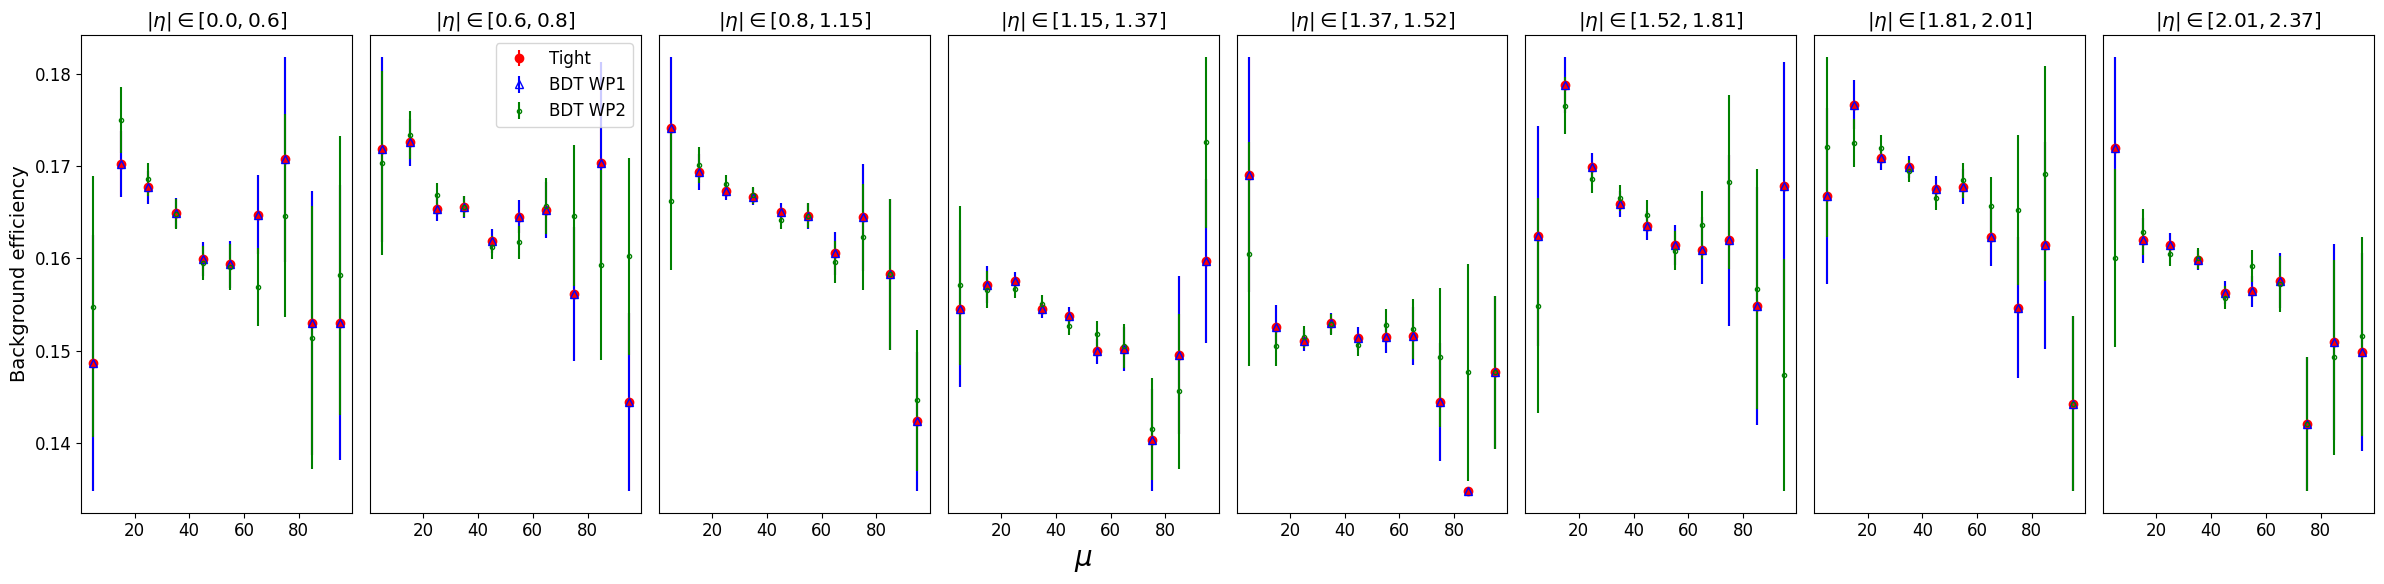

In [50]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_bkg_tight_EtaMu[i], efferr_bkg_tight_EtaMu[i],
                   fmt="o", label='Tight', color = 'red')
    ax[i].errorbar(mu, eff_bkg_bdt_mueta_EtaMu[i], efferr_bkg_bdt_mueta_EtaMu[i],
                   fmt="^", fillstyle='none', label='BDT WP1', color = 'blue')
    ax[i].errorbar(mu, eff_bkg_bdt_pteta_EtaMu[i], efferr_bkg_bdt_pteta_EtaMu[i],
                   fmt=".", fillstyle='none', label='BDT WP2', color = 'green')
    if (i!=0): ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    #ax[i].set_ylim([0.,0.5])
    
ax[0].set_ylabel("Background efficiency",  fontsize=14)
ax[3].set_xlabel("$\mu$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

plt.tight_layout()
plt.show()

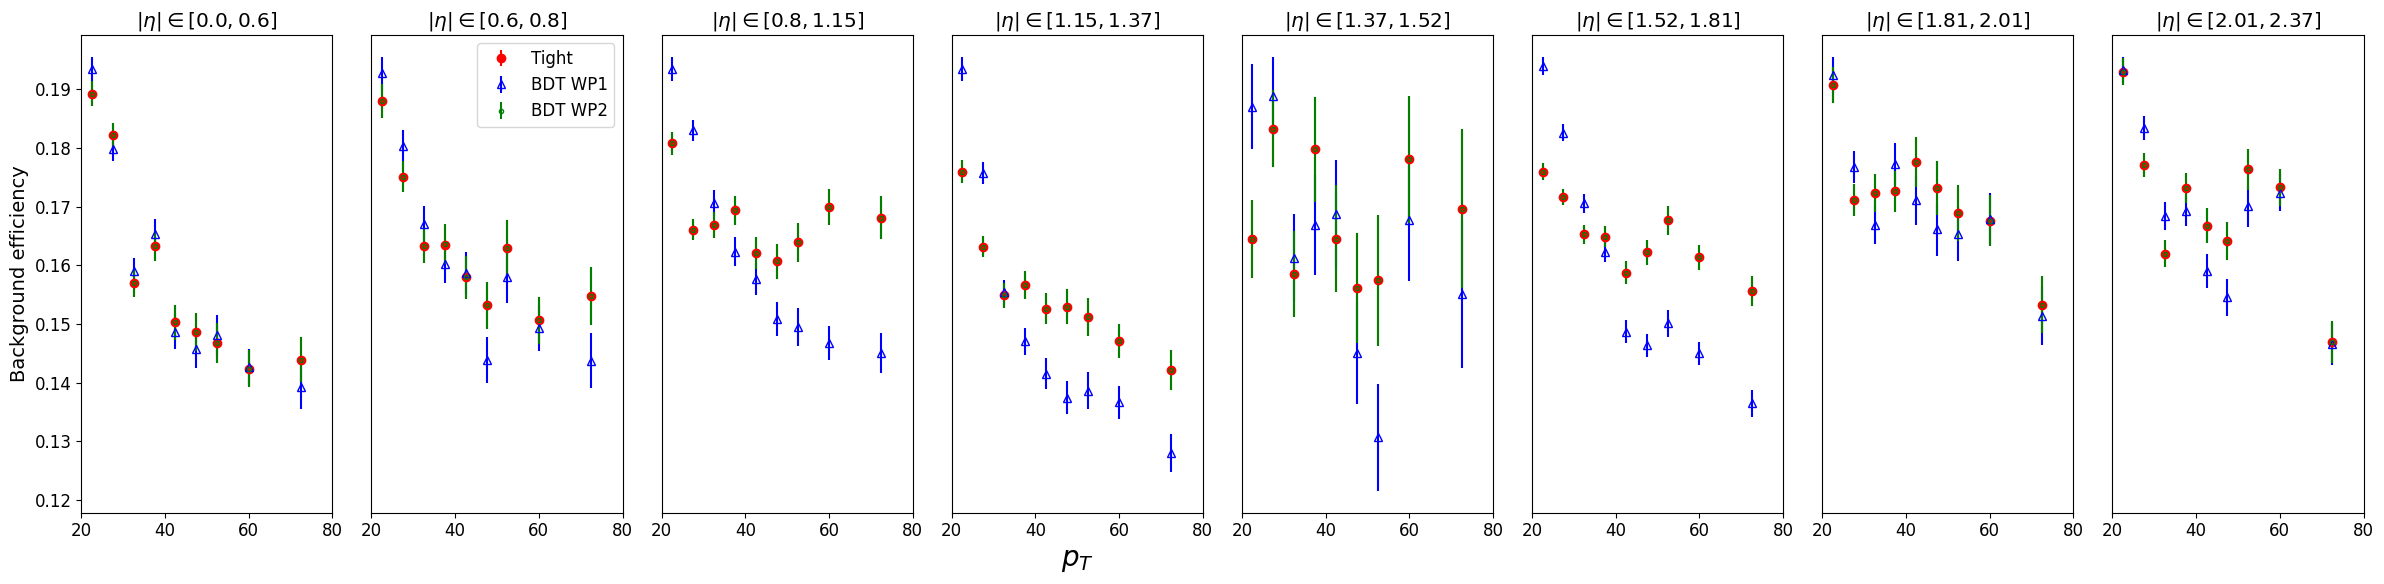

In [51]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(pt_bkg, eff_bkg_tight_EtapT[i], efferr_bkg_tight_EtapT[i],
                   fmt="o", label='Tight', color = 'red')
    ax[i].errorbar(pt_bkg, eff_bkg_bdt_mueta_EtapT[i], efferr_bkg_bdt_mueta_EtapT[i],
                   fmt="^", fillstyle='none', label='BDT WP1', color = 'blue')
    ax[i].errorbar(pt_bkg, eff_bkg_bdt_pteta_EtapT[i], efferr_bkg_bdt_pteta_EtapT[i],
                   fmt=".", fillstyle='none', label='BDT WP2', color = 'green')
    if (i!=0): 
        ax[i].set_yticks([])
    ax[i].set_xlim([20.,80.])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    #ax[i].set_ylim([0.,0.5])
    
ax[0].set_ylabel("Background efficiency",  fontsize=14)
ax[3].set_xlabel("$p_T$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

plt.tight_layout()
plt.show()

* As a function of $\mu$ for true photons: we expect an improvement, both in the efficiency and possibly on the dependence on $\mu$

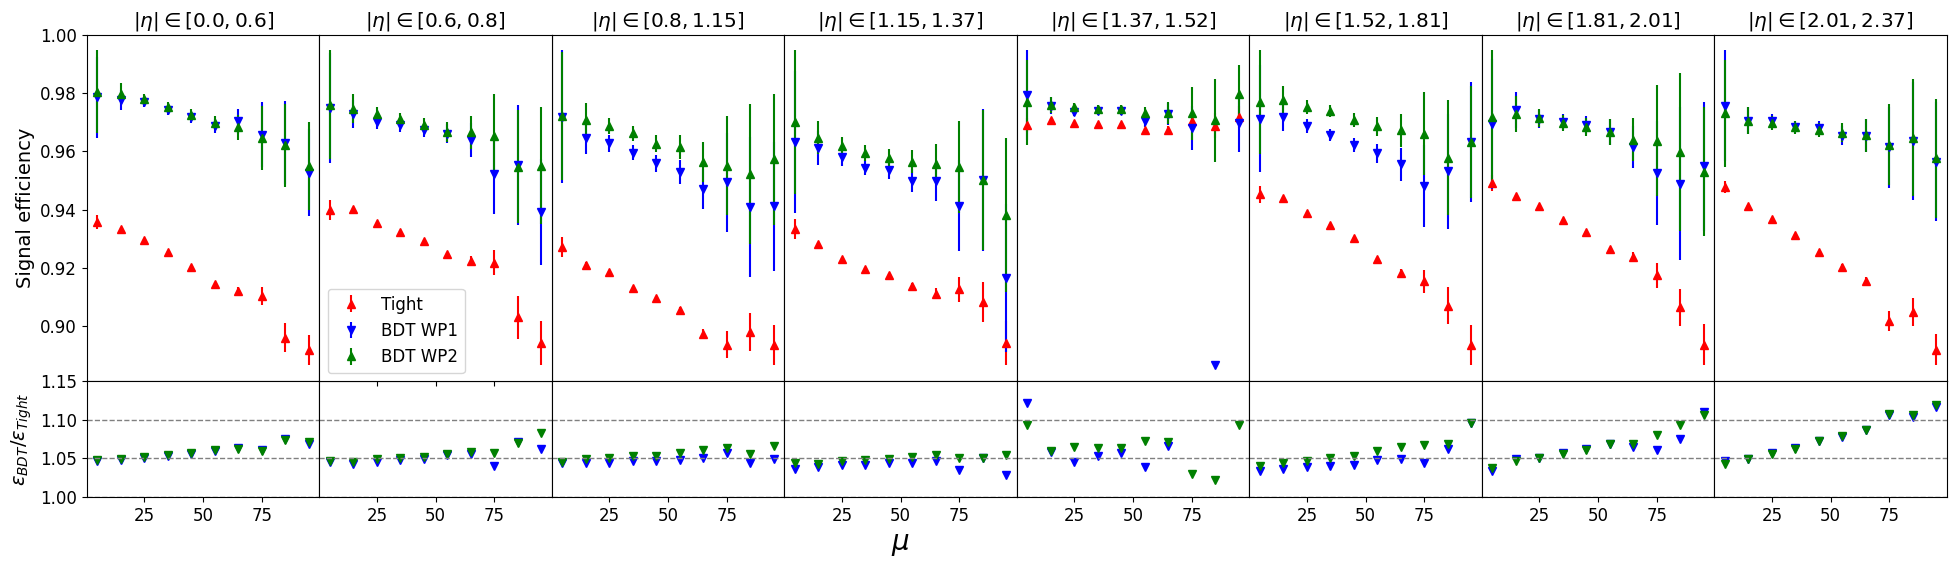

In [52]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24,6), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_sig_tight_EtaMu[i], efferr_sig_tight_EtaMu[i],
        fmt="^", label='Tight', color = 'red')
    ax[i].errorbar(mu, eff_sig_bdt_mueta_EtaMu[i], efferr_bkg_bdt_mueta_EtaMu[i],
        fmt="v", label='BDT WP1', color = 'blue')
    ax[i].errorbar(mu, eff_sig_bdt_pteta_EtaMu[i], efferr_bkg_bdt_pteta_EtaMu[i],
        fmt="^", label='BDT WP2', color = 'green')    
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(mu, eff_sig_bdt_mueta_EtaMu[i]/eff_sig_tight_EtaMu[i], 'v', color = 'blue', label="BDT WP1/Tight")
    rax[i].plot(mu, eff_sig_bdt_pteta_EtaMu[i]/eff_sig_tight_EtaMu[i], 'v', color = 'green', label="BDT WP2/Tight")    
    rax[i].axhline(y=1.00, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.05, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.10, color='grey', linestyle='--', linewidth=1)
    rax[i].set_ylim([1., 1.15])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$\mu$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

plt.show()

* as a function of $p_T$: we want to check that, since the WP cuts are not parameterized as a function of $p_T$, nothing weird happens and the gain is also observed for all $p_T$ range:

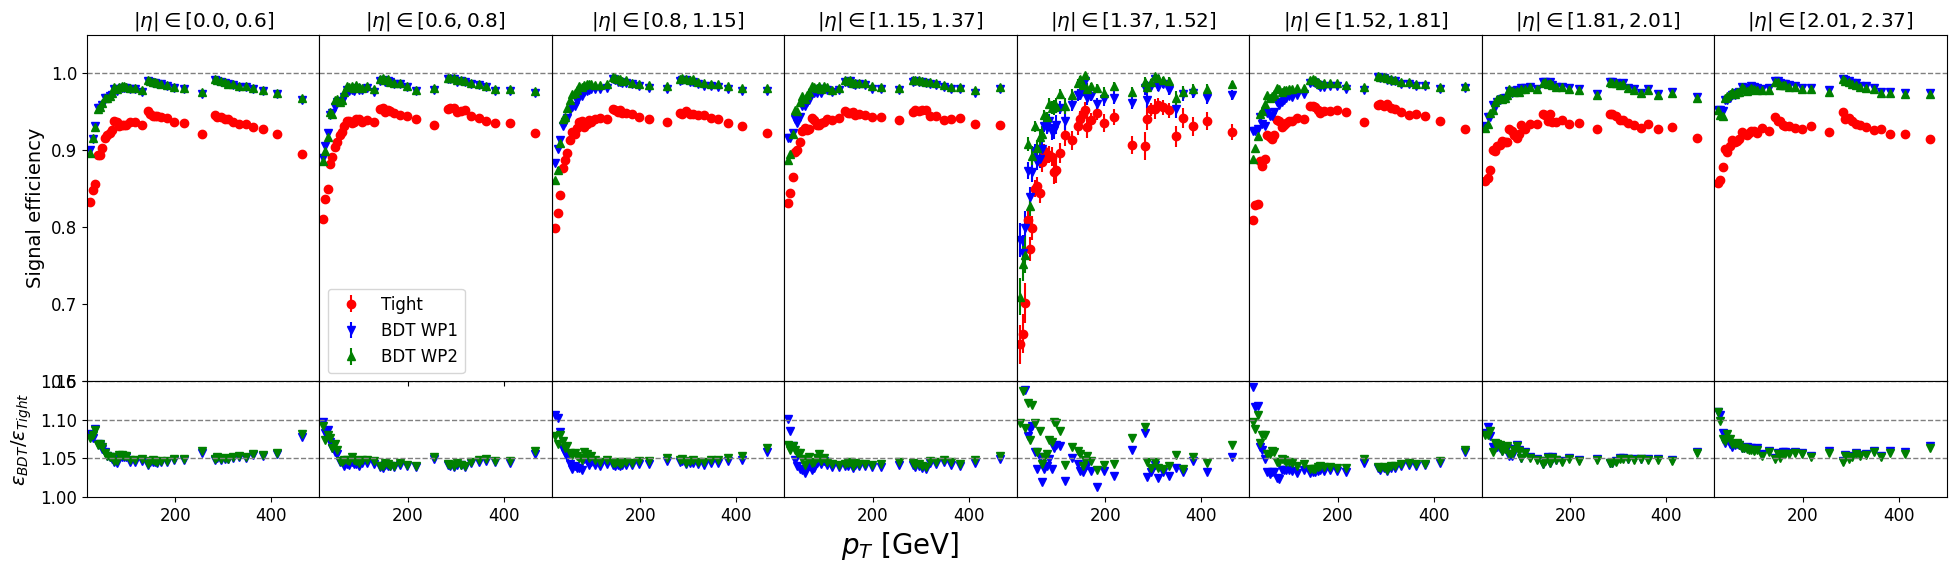

In [53]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24,6), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(pt_sig, eff_sig_tight_EtapT[i], efferr_sig_tight_EtapT[i],
        fmt="o", label='Tight', color = 'red')
    ax[i].errorbar(pt_sig, eff_sig_bdt_mueta_EtapT[i], efferr_sig_bdt_mueta_EtapT[i],
        fmt="v", label='BDT WP1', color = 'blue')
    ax[i].errorbar(pt_sig, eff_sig_bdt_pteta_EtapT[i], efferr_sig_bdt_pteta_EtapT[i],
        fmt="^", label='BDT WP2', color = 'green')
    if (i!=0):
        ax[i].set_yticks([])
    ax[i].set_ylim([0.6, 1.05])
    ax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(pt_sig, eff_sig_bdt_mueta_EtapT[i]/eff_sig_tight_EtapT[i], 'v', color = 'blue', label="BDT WP1/Tight")
    rax[i].plot(pt_sig, eff_sig_bdt_pteta_EtapT[i]/eff_sig_tight_EtapT[i], 'v', color = 'green', label="BDT WP2/Tight")
    rax[i].axhline(y=1.05, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.10, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.15, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([15, 5*10**2])
    rax[i].set_ylim([1, 1.15])

    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$p_{T}$ [GeV]",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)

plt.show()

In [29]:
num_sig_bdt_pteta_EtaMu

Hist(
  Variable([0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37], name='eta', label='$\\eta$'),
  Variable([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], name='mu', label='$\\mu$'),
  storage=Double()) # Sum: 5760776.0

In [30]:
num_sig_bdt_pteta_EtapT

Hist(
  Variable([0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37], name='eta', label='$\\eta$'),
  Variable(array([ 20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,  65.,  70.,
        75.,  80.,  85.,  90.,  95., 100., 110., 120., 140., 145., 150.,
       155., 160., 165., 175., 190., 205., 230., 280., 285., 290., 300.,
       305., 315., 325., 340., 355., 370., 395., 430., 500.]), name='pt', label='$p_T$ [GeV]'),
  storage=Double()) # Sum: 5760776.0

In [31]:
den_sig_EtapT

Hist(
  Variable([0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37], name='eta', label='$\\eta$'),
  Variable(array([ 20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,  65.,  70.,
        75.,  80.,  85.,  90.,  95., 100., 110., 120., 140., 145., 150.,
       155., 160., 165., 175., 190., 205., 230., 280., 285., 290., 300.,
       305., 315., 325., 340., 355., 370., 395., 430., 500.]), name='pt', label='$p_T$ [GeV]'),
  storage=Double()) # Sum: 5903982.0 (5912956.0 with flow)

In [32]:
den_sig_EtaMu

Hist(
  Variable([0, 0.6, 0.8, 1.15, 1.37, 1.52, 1.81, 2.01, 2.37], name='eta', label='$\\eta$'),
  Variable([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], name='mu', label='$\\mu$'),
  storage=Double()) # Sum: 5903982.0 (5912956.0 with flow)